# calculate thresholds

In [1]:
!pip -q install earthaccess

In [2]:
import pandas as pd
import glob
import create_dataset
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
from sklearn.metrics import roc_curve, confusion_matrix, roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier


In [3]:
dataframes_folder = 'data/dataframes/'
fn = 'grandmesa_2023_tar_2023-06-01_ref_2023-06-01_2023-09-01_median_100.parquet'
fn = 'iceland_trollaskagi_peninsula_2023_tar_2023-06-01_ref_2023-06-01_2023-09-01_median_100.parquet'
fn = 'iceland_trollaskagi_peninsula_2015_tar_2015-06-27_ref_2015-01-01_2015-03-01_median_100.parquet'
fn = 'iceland_trollaskagi_peninsula_2015_tar_2015-06-27_ref_2015-01-01_2015-12-31_median_100.parquet'
fn = 'iceland_trollaskagi_peninsula_2015_tar_2015-06-27_ref_2015-01-01_2015-12-31_median_100.parquet'
fn = 'iceland_trollaskagi_peninsula_2015_tar_2015-06-27_ref_2015-01-01_2015-03-31_median_100.parquet'

dataframe = pd.read_parquet(f'{dataframes_folder}{fn}')

In [4]:
ndsi_thresh = 40 #[40,70]

In [5]:
dataframe = create_dataset.dataframe_ndsi_to_binary(dataframe,ndsi_thresh)

In [6]:
bins = [0,10,20,30,40,50,60,70,80,90,100]
labels = ['0-10','10-20','20-30','30-40','40-50','50-60','60-70','70-80','80-90','90-100']


# Create bins for the 'local_incidence_angle' column
dataframe['local_incidence_angle_bins'] = pd.cut(dataframe['local_incidence_angle'], bins=bins, labels=labels)

dataframe['forest_cover_fraction_bins'] = pd.cut(dataframe['forest_cover_fraction'], bins=bins, labels=labels)

In [7]:
dataframe.corr(numeric_only=True)

,y,x,sat:relative_orbit,spatial_ref,ratio_images,local_incidence_angle,esa_worldcover,forest_cover_fraction,snow_class,modis_ndsi,modis_binary
y,1.000000,0.103761,0.111777,NaN,0.029547,0.040891,0.030711,0.040213,0.091188,0.042196,0.031930
x,0.103761,1.000000,0.130848,NaN,0.046795,0.002913,-0.000808,0.014599,0.019088,0.023420,0.029124
sat:relative_orbit,0.111777,0.130848,1.000000,NaN,-0.066389,-0.071361,-0.006874,0.016774,0.027273,-0.027001,-0.021914
spatial_ref,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ratio_images,0.029547,0.046795,-0.066389,NaN,1.000000,0.067712,-0.311158,0.189136,0.456515,-0.621281,-0.546295
local_incidence_angle,0.040891,0.002913,-0.071361,NaN,0.067712,1.000000,0.044486,-0.026854,-0.060548,0.061698,0.057228
esa_worldcover,0.030711,-0.000808,-0.006874,NaN,-0.311158,0.044486,1.000000,-0.280181,-0.455639,0.373298,0.351235
forest_cover_fraction,0.040213,0.014599,0.016774,NaN,0.189136,-0.026854,-0.280181,1.000000,0.303673,-0.262073,-0.247789
snow_class,0.091188,0.019088,0.027273,NaN,0.456515,-0.060548,-0.455639,0.303673,1.000000,-0.585408,-0.554662
modis_ndsi,0.042196,0.023420,-0.027001,NaN,-0.621281,0.061698,0.373298,-0.262073,-0.585408,1.000000,0.965198


In [8]:
dataframe['local_incidence_angle_bins'].value_counts()

local_incidence_angle_bins
30-40     1582688
40-50     1555709
50-60      668250
20-30      597360
60-70      346320
10-20      241897
70-80      142239
0-10        59425
80-90       22961
90-100       2435
Name: count, dtype: int64

In [9]:
#dataframe = create_dataset.dataframe_numbers_to_classes(dataframe)

In [10]:
parts = fn.split('_')
target_time = parts[parts.index('tar') + 1]

time_diff = (dataframe['time'] - pd.to_datetime(target_time)).abs()
mask = time_diff <= pd.Timedelta(days=10)

dataframe = dataframe[mask]

In [11]:
pal = {0:'peru',1:'dodgerblue'} 

In [12]:
def calculate_threshold_otsu(group):
    values = group['ratio_images'].values
    return threshold_otsu(values)


def calculate_threshold_logistic(group):
    X = group[['ratio_images']]
    y = group['modis_binary']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    model = LogisticRegression()
    model.fit(X_train, y_train)
    difference_array = np.absolute(0.5-model.predict_proba(X)[:,1])
    index = difference_array.argmin()
    thresh = X.values[index][0]
    return thresh 

def calculate_roc_auc_logistic(group):
    X = group[['ratio_images']]
    y = group['modis_binary']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    model = LogisticRegression()
    model.fit(X_train, y_train)
    
    auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1],average='weighted') # add average
    
    return auc 


def calculate_accuracy_logistic(group):
    X = group[['ratio_images']]
    y = group['modis_binary']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    model = LogisticRegression()
    model.fit(X_train, y_train)
    acc = model.score(X_test,y_test)
    
    return acc

In [13]:
thresholds_otsu = dataframe.groupby(['sat:orbit_state','band','local_incidence_angle_bins']).apply(calculate_threshold_otsu).reset_index(level=[0,1])

In [14]:
thresholds_logistic = dataframe.groupby(['sat:orbit_state','band','local_incidence_angle_bins']).apply(calculate_threshold_logistic).reset_index(level=[0,1])

In [15]:
roc_auc_logistic = dataframe.groupby(['sat:orbit_state','band','local_incidence_angle_bins']).apply(calculate_roc_auc_logistic).reset_index(level=[0,1])

In [16]:
accuracy_logistic = dataframe.groupby(['sat:orbit_state','band','local_incidence_angle_bins']).apply(calculate_accuracy_logistic).reset_index(level=[0,1])

In [17]:
thresholds = thresholds_logistic

In [18]:
#thresholds_roc = pd.DataFrame(dataframe.groupby(['sat:orbit_state','band','local_incidence_angle_bins']).apply(calculate_threshold_roc))

In [19]:
#thresholds_roc = thresholds_roc.reset_index(level=[0,1])

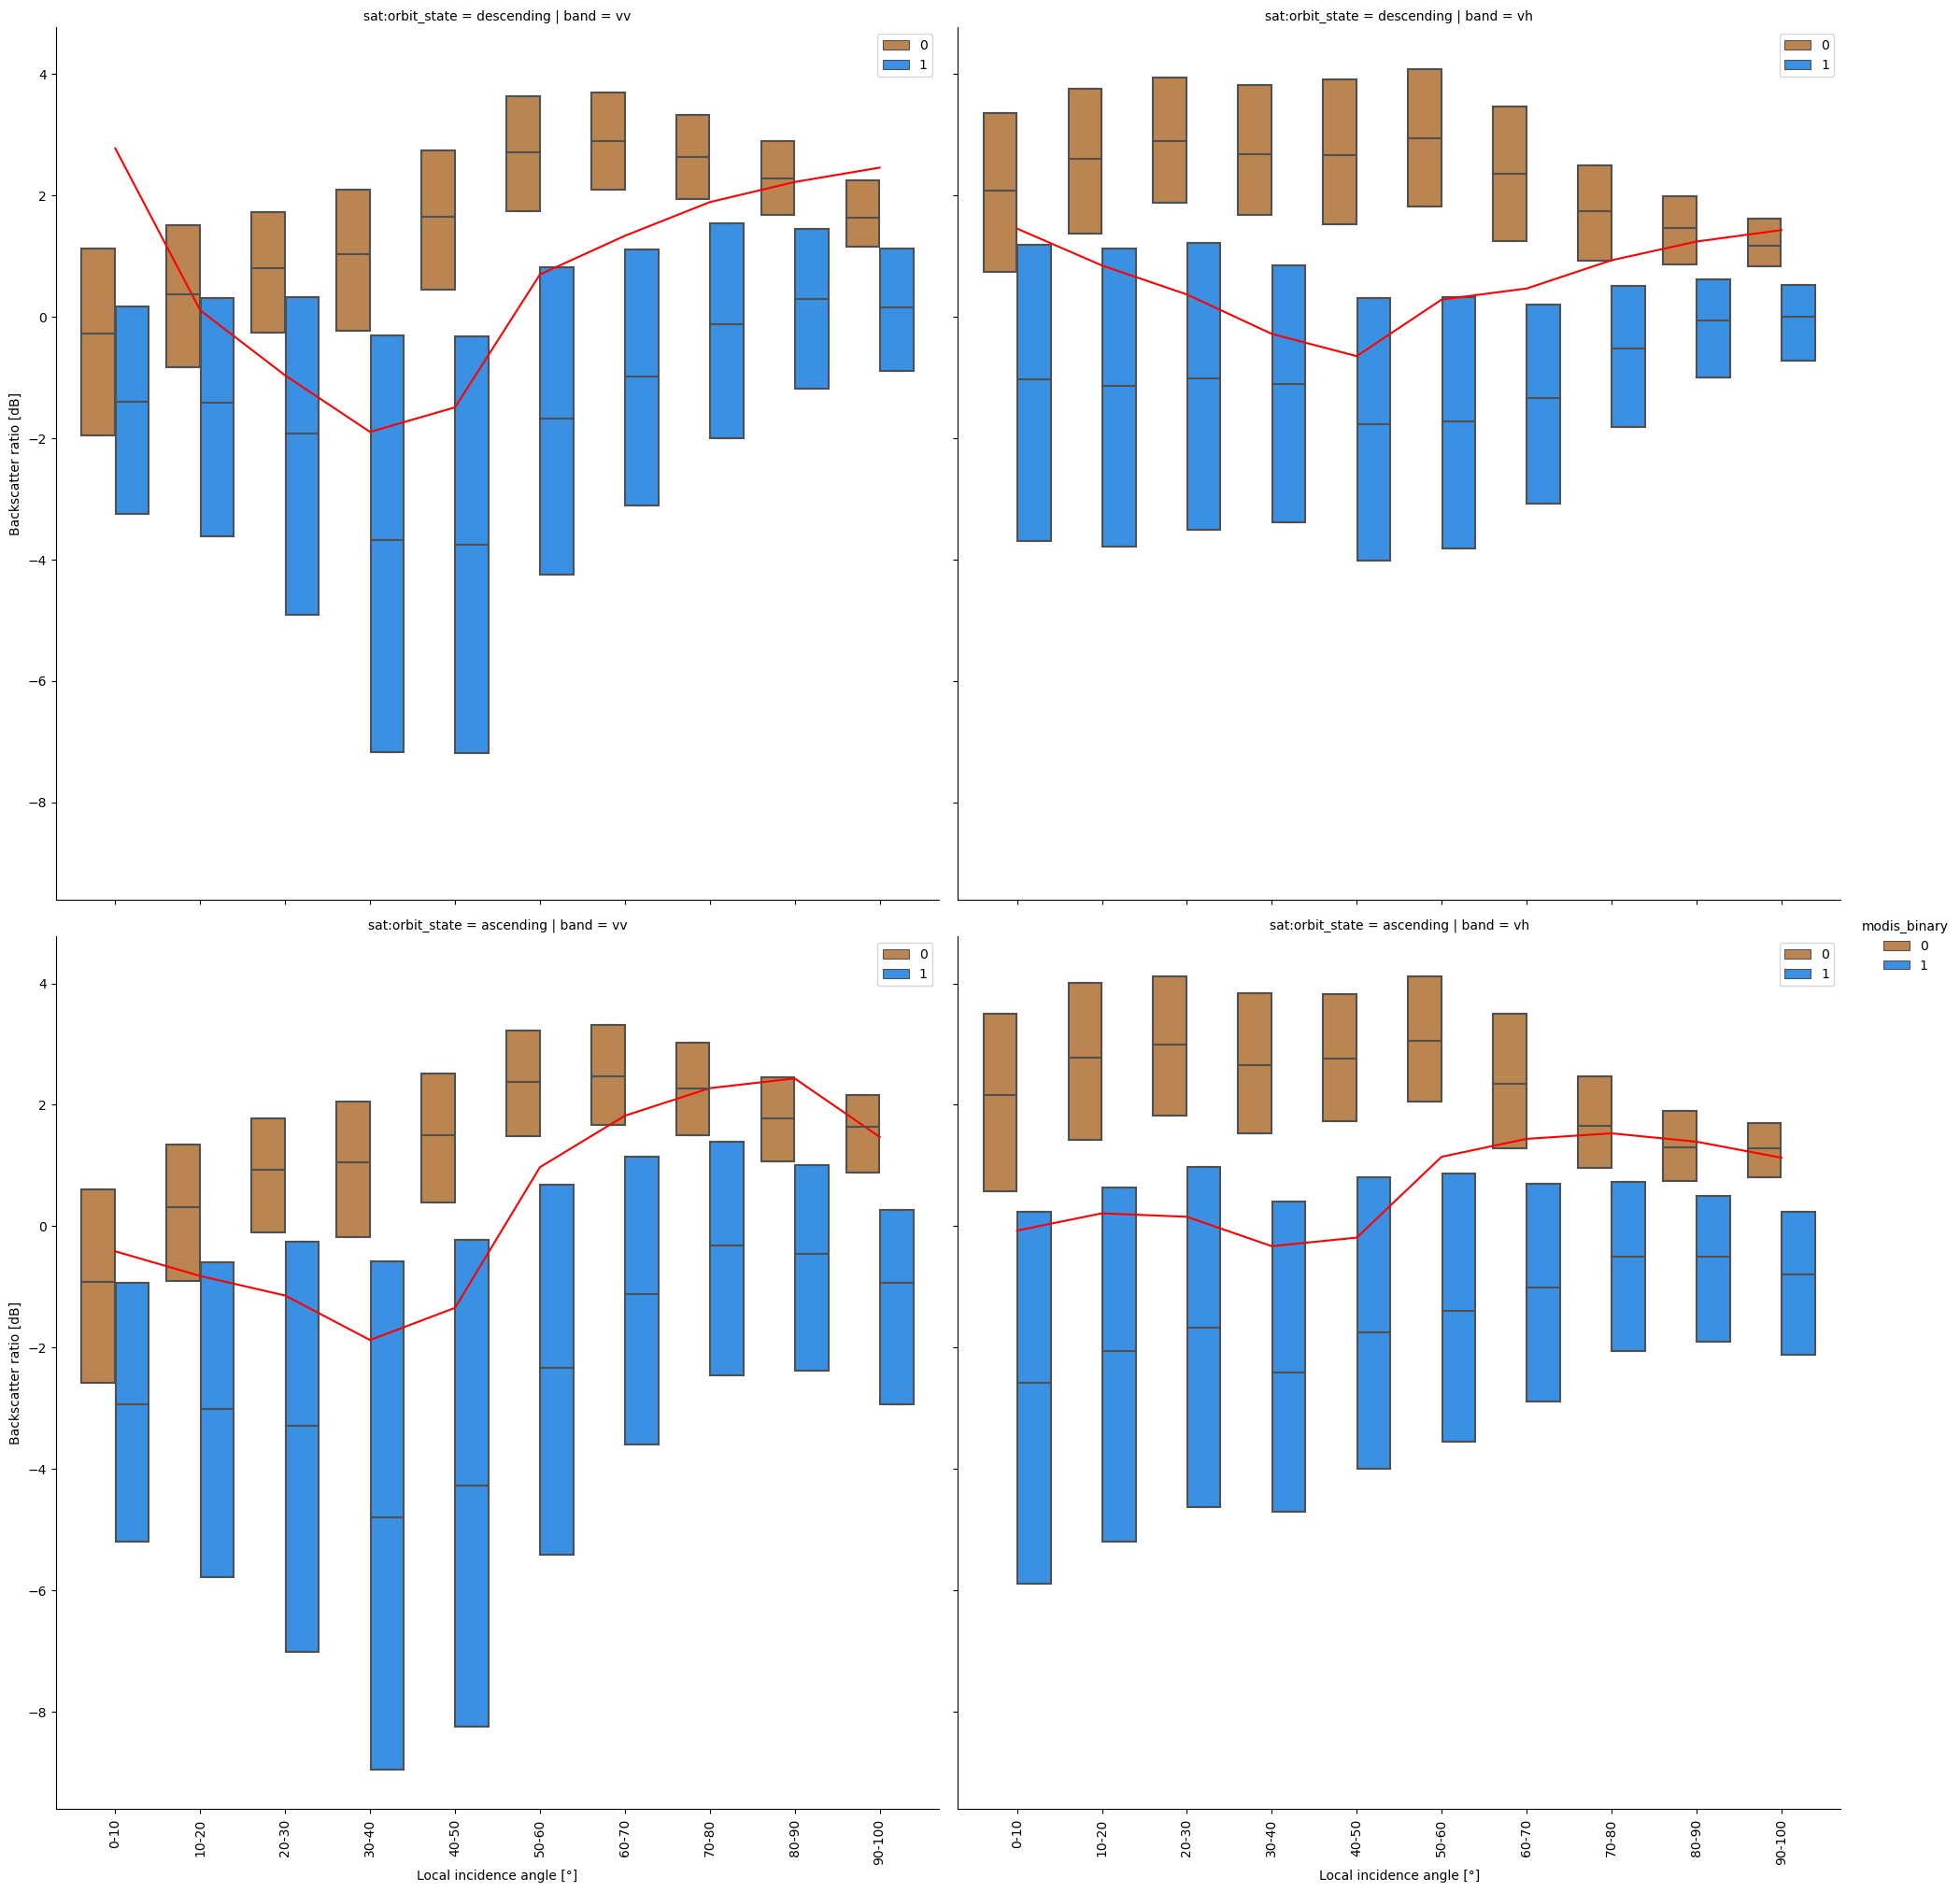

In [20]:
g = sns.catplot(x='local_incidence_angle_bins', y='ratio_images', hue="modis_binary", data=dataframe,
               row="sat:orbit_state", col='band', kind='box', showfliers=False, whis=0, palette=pal, height=10)

row_values = dataframe['sat:orbit_state'].unique()
col_values = dataframe['band'].unique()
row_indices = {value: i for i, value in enumerate(row_values)}
col_indices = {value: i for i, value in enumerate(col_values)}


for (row_value, col_value), _ in g.axes_dict.items():
        row_index = row_indices[row_value]
        col_index = col_indices[col_value]
        
        sns.lineplot(thresholds[(thresholds['sat:orbit_state'] == row_value) & (thresholds['band'] == col_value)],
                     x="local_incidence_angle_bins", y=0, color='red', ax=g.facet_axis(row_index, col_index))
        

for ax in g.axes.flat:
    ax.tick_params(axis='x', rotation=90)
    ax.set_ylabel('Backscatter ratio [dB]')
    ax.set_xlabel('Local incidence angle [\N{degree sign}]')

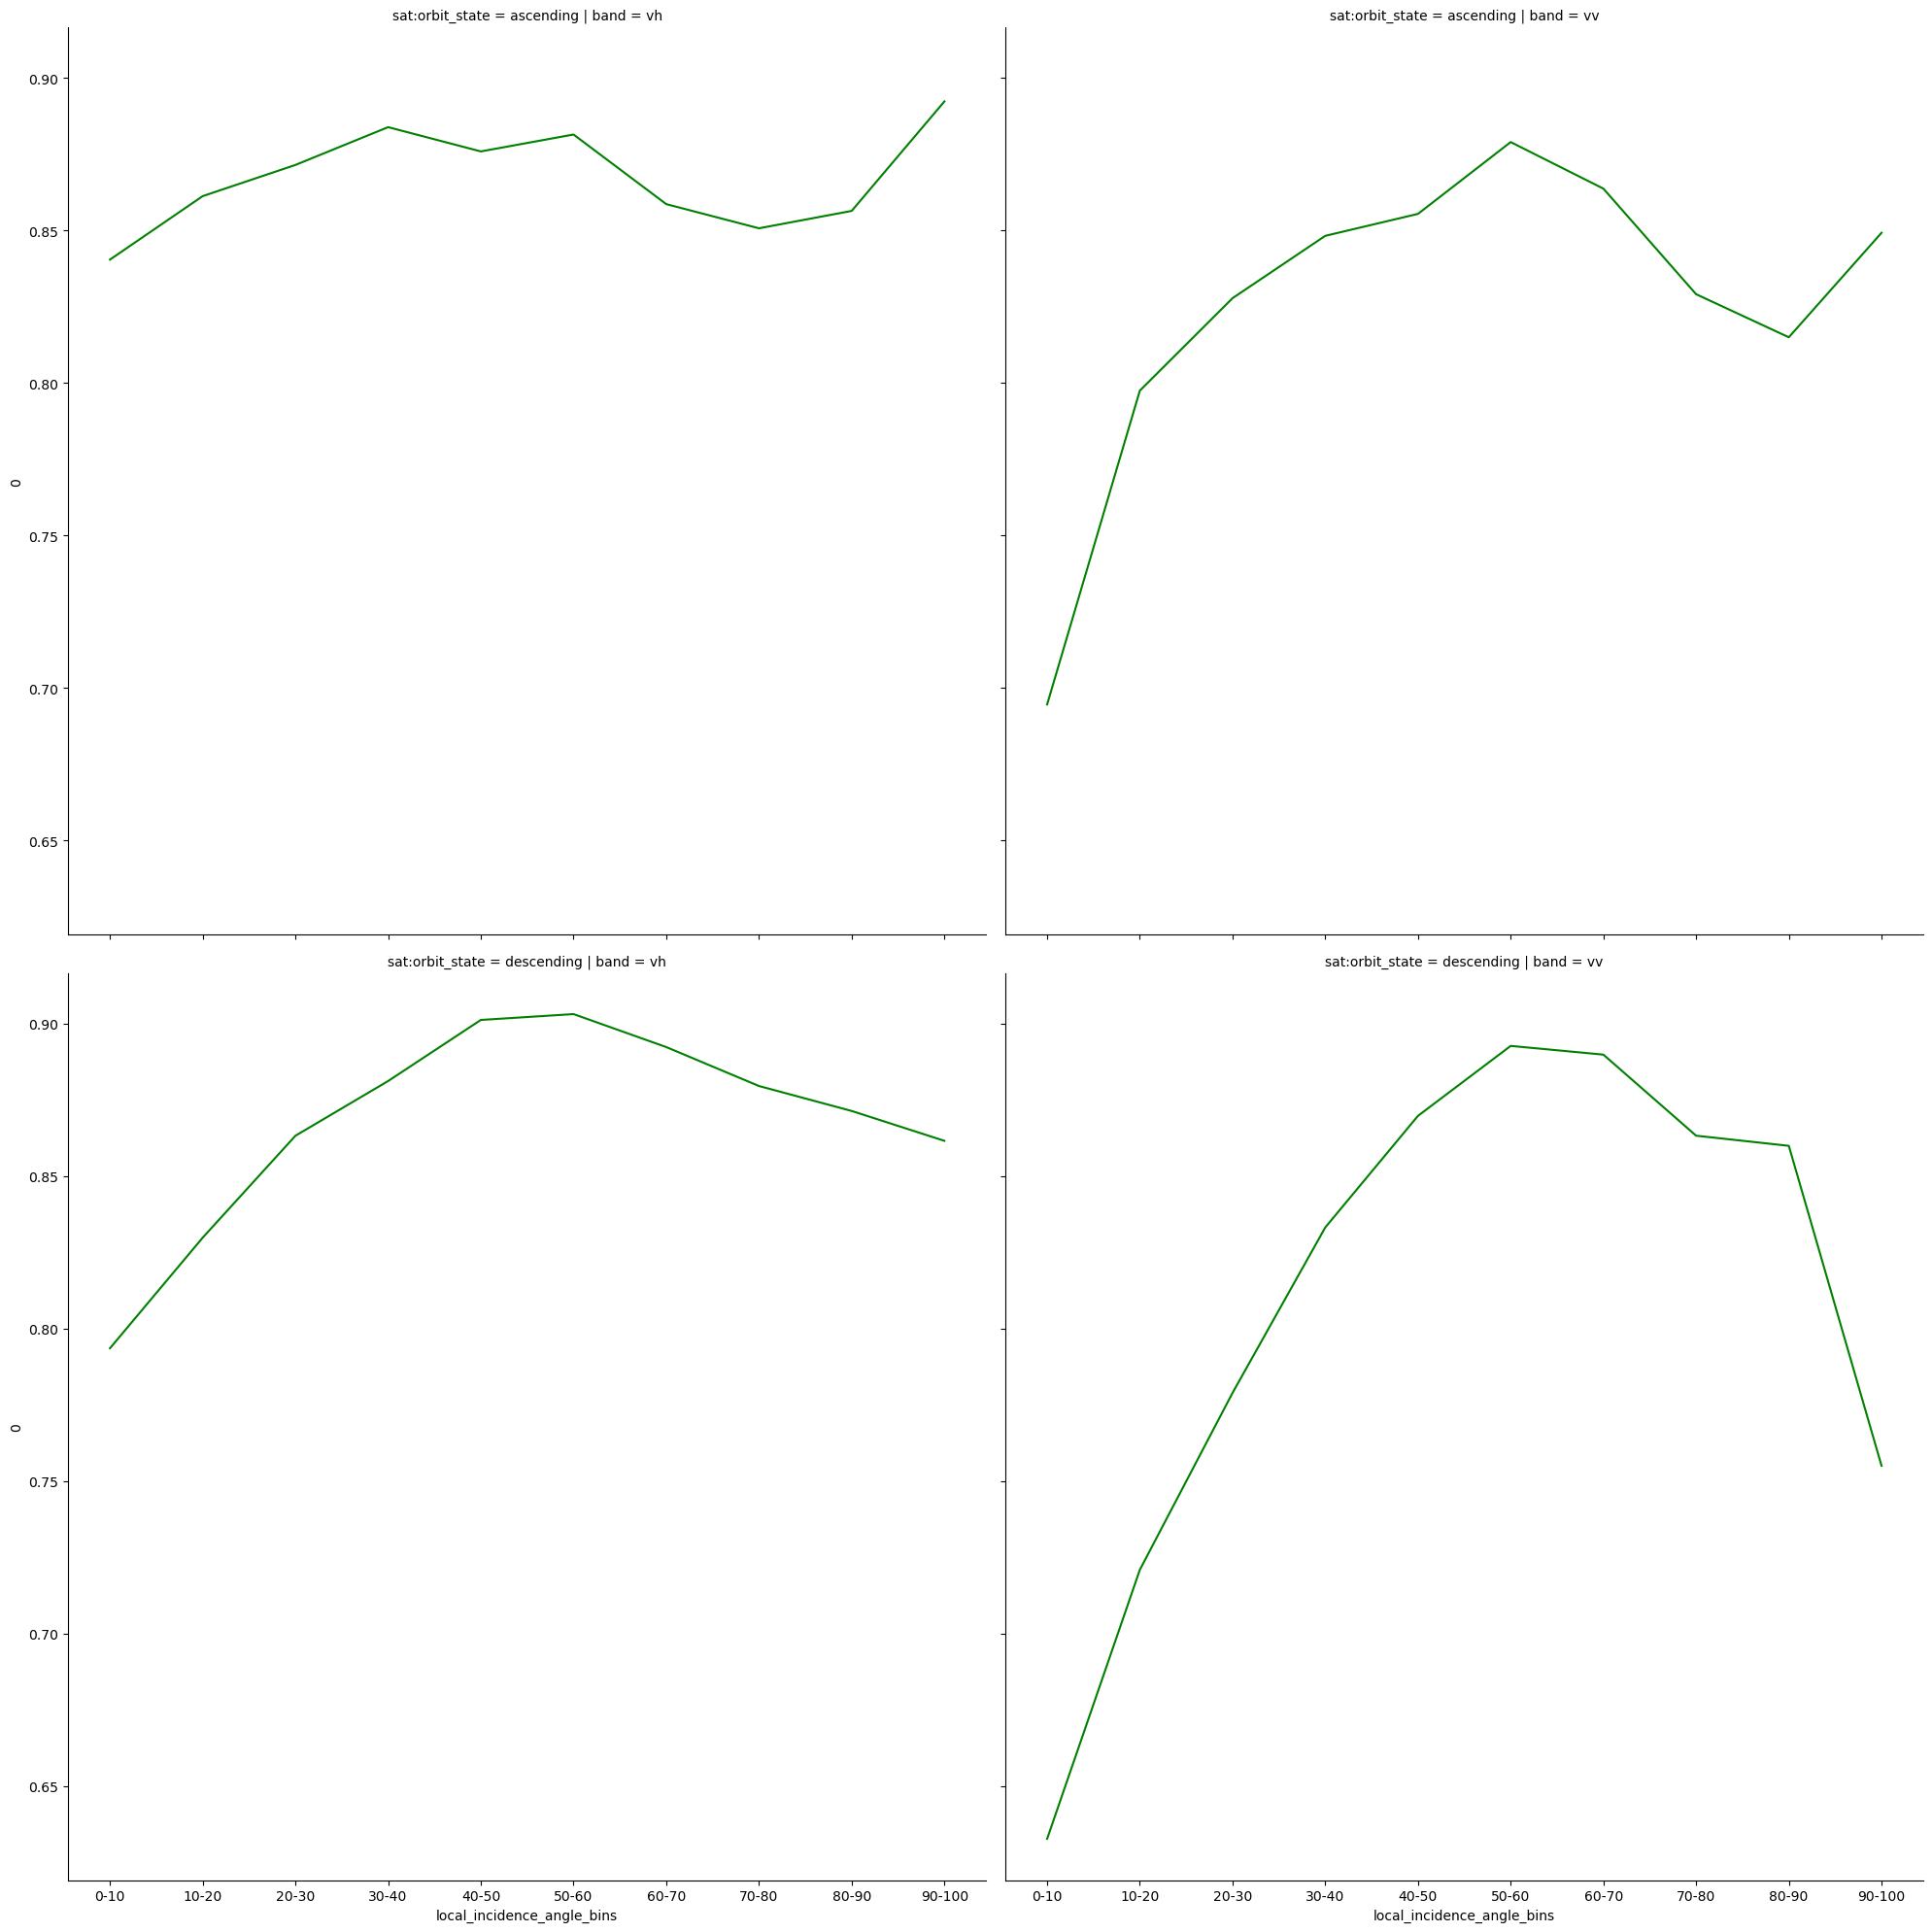

In [21]:
g = sns.FacetGrid(roc_auc_logistic,row="sat:orbit_state", col='band',height=10)

# Define a function to plot on each facet
def plot_func(data, color, **kwargs):
    ax = plt.gca()
    sns.lineplot(data=data, x="local_incidence_angle_bins", y=0, color=color, ax=ax)

# Map the function to the FacetGrid
g = g.map_dataframe(plot_func, color='green')

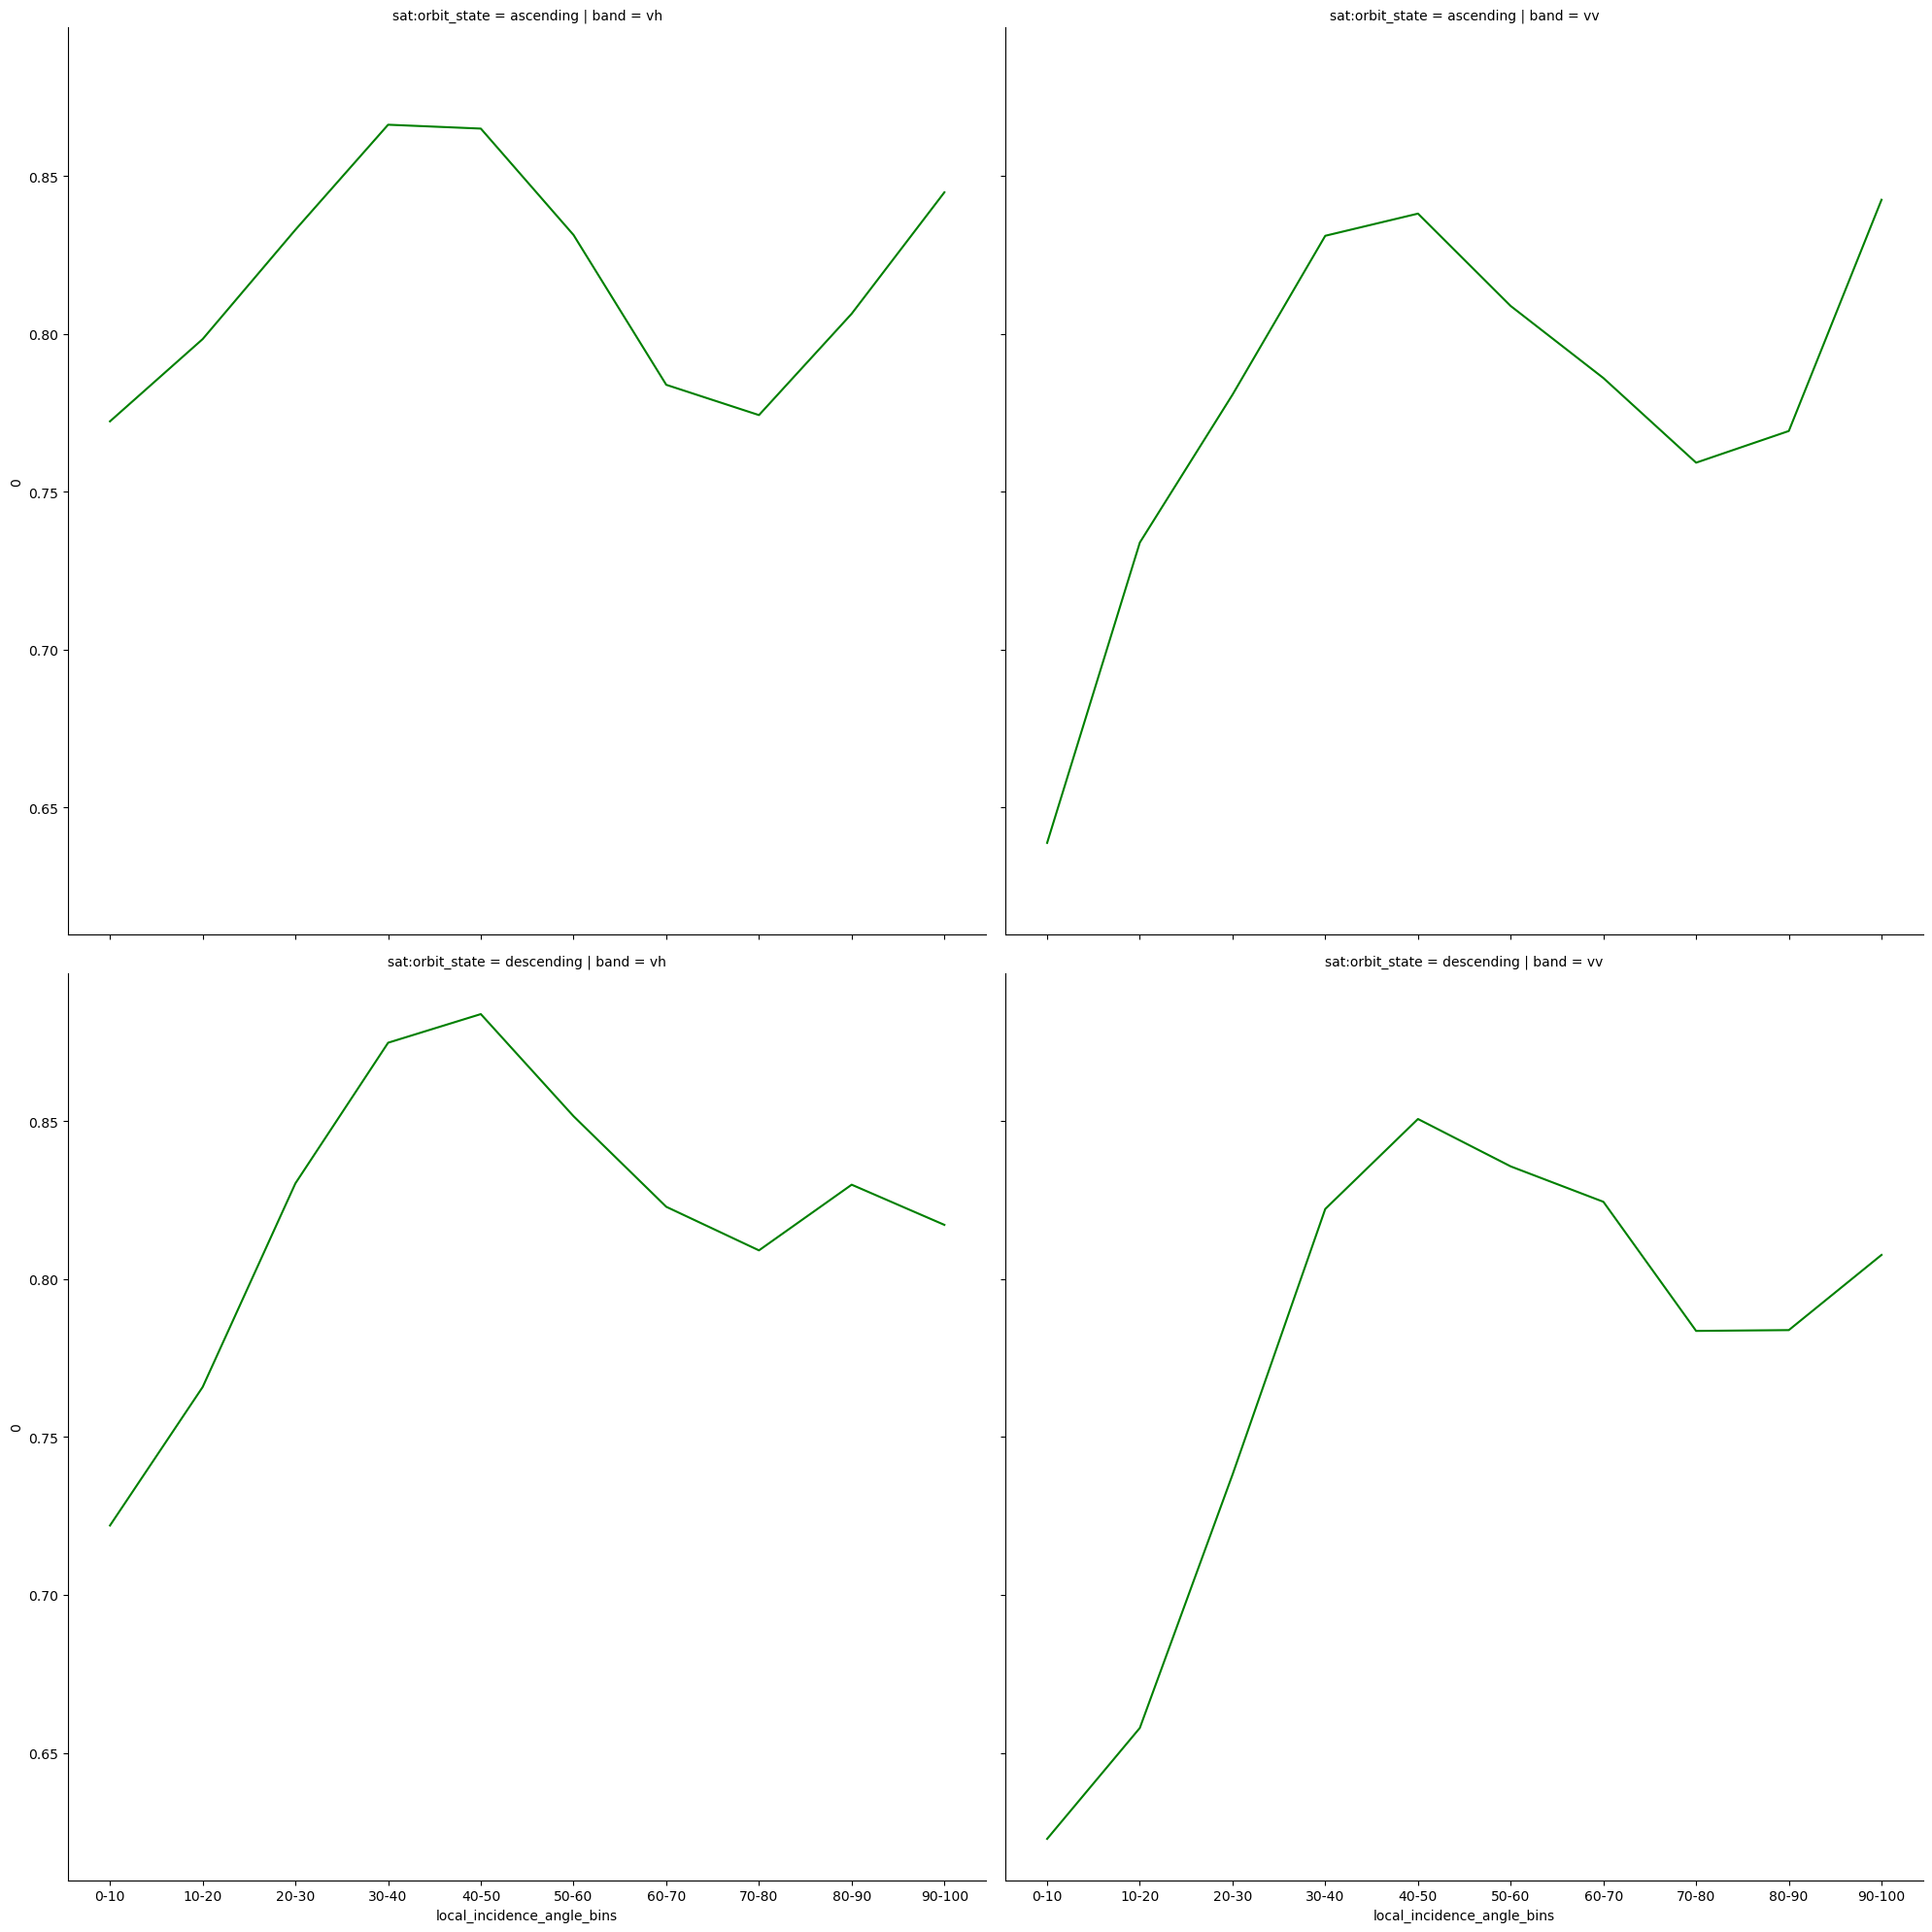

In [22]:
g = sns.FacetGrid(accuracy_logistic,row="sat:orbit_state", col='band',height=10)

# Define a function to plot on each facet
def plot_func(data, color, **kwargs):
    ax = plt.gca()
    sns.lineplot(data=data, x="local_incidence_angle_bins", y=0, color=color, ax=ax)

# Map the function to the FacetGrid
g = g.map_dataframe(plot_func, color='green')

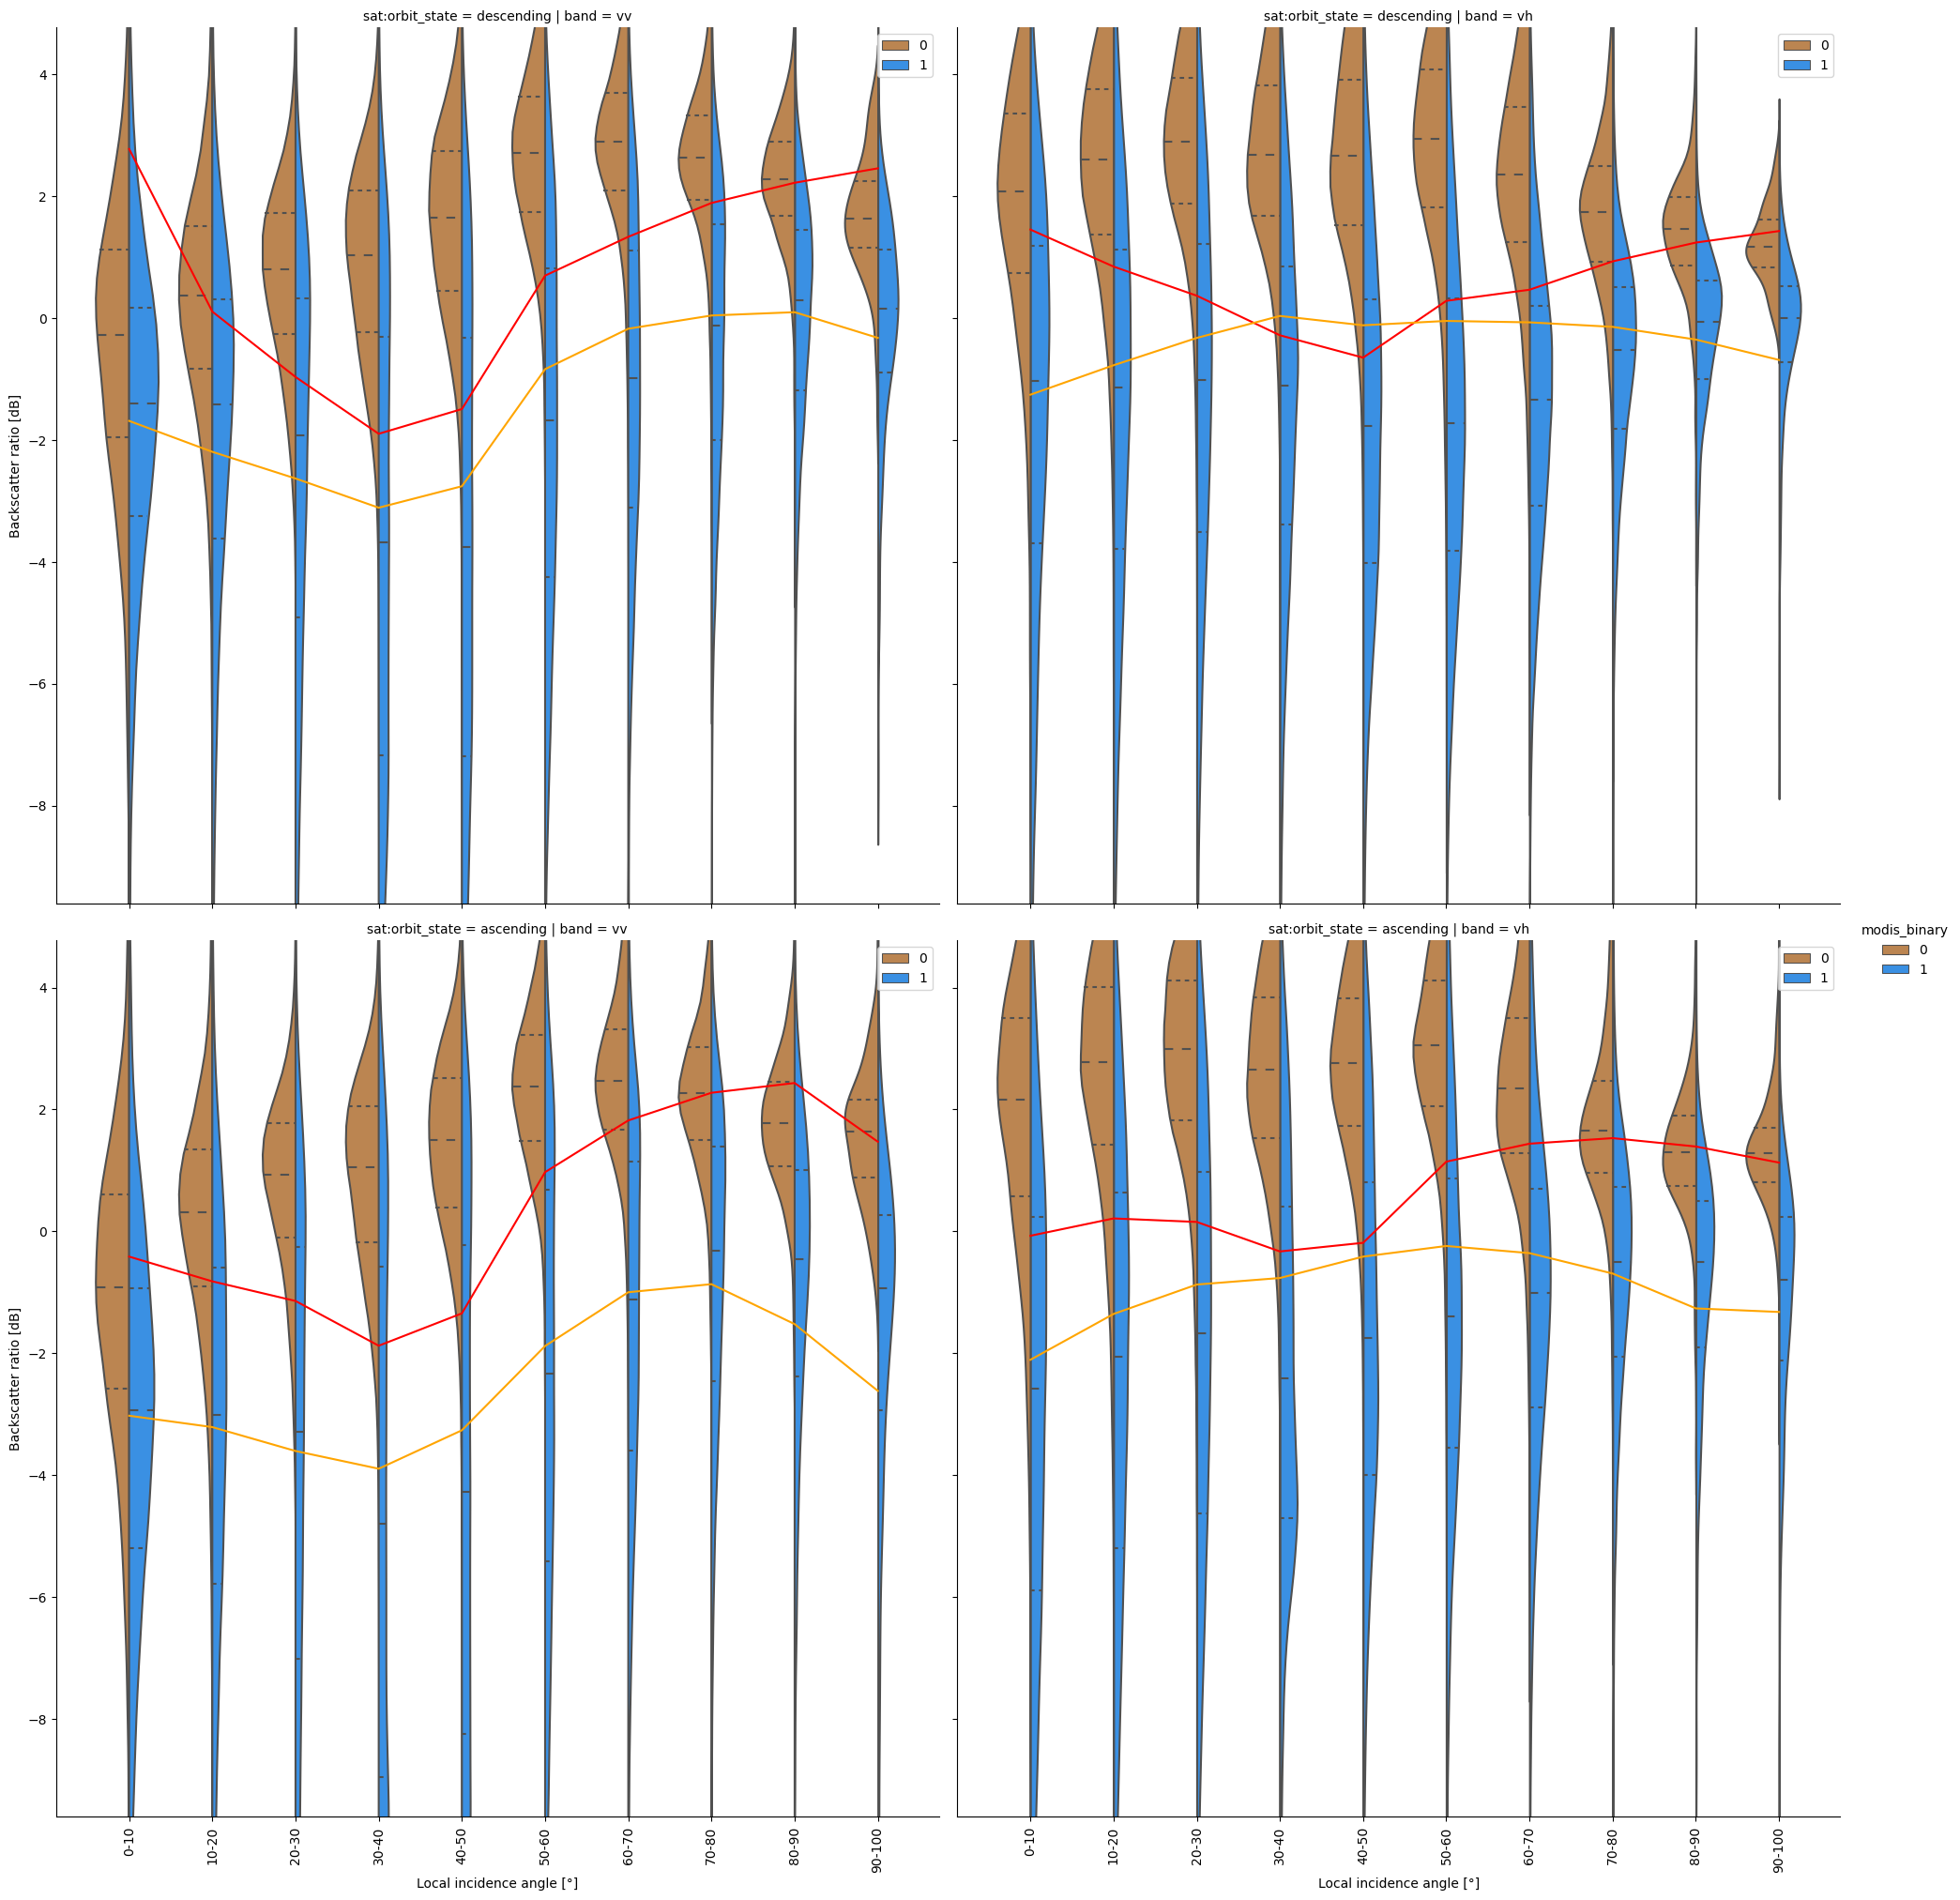

In [23]:
g = sns.catplot(x='local_incidence_angle_bins', y='ratio_images', hue="modis_binary", data=dataframe,
               row="sat:orbit_state", col='band', kind='violin',split=True,inner='quart', palette=pal, height=10)

row_values = dataframe['sat:orbit_state'].unique()
col_values = dataframe['band'].unique()
row_indices = {value: i for i, value in enumerate(row_values)}
col_indices = {value: i for i, value in enumerate(col_values)}
        
for (row_value, col_value), _ in g.axes_dict.items():
        row_index = row_indices[row_value]
        col_index = col_indices[col_value]
        
        sns.lineplot(thresholds_logistic[(thresholds_logistic['sat:orbit_state'] == row_value) & (thresholds_logistic['band'] == col_value)],
                     x="local_incidence_angle_bins", y=0, color='red', ax=g.facet_axis(row_index, col_index))
        sns.lineplot(thresholds_otsu[(thresholds_otsu['sat:orbit_state'] == row_value) & (thresholds_otsu['band'] == col_value)],
                     x="local_incidence_angle_bins", y=0, color='orange', ax=g.facet_axis(row_index, col_index))

for ax in g.axes.flat:
    ax.tick_params(axis='x', rotation=90)
    ax.set_ylabel('Backscatter ratio [dB]')
    ax.set_xlabel('Local incidence angle [\N{degree sign}]')

In [24]:
# some sort of uncertainty estimate, seperability score. maybe something with euclidean distance

In [25]:
# 2d surface of threshold

In [26]:
# why is roc curve reversed

In [27]:
#dataframe.groupby(['sat:orbit_state','band'])

In [52]:
#new_dataframe = dataframe[(dataframe['sat:orbit_state']=='descending') & (dataframe['band']=='vv')]


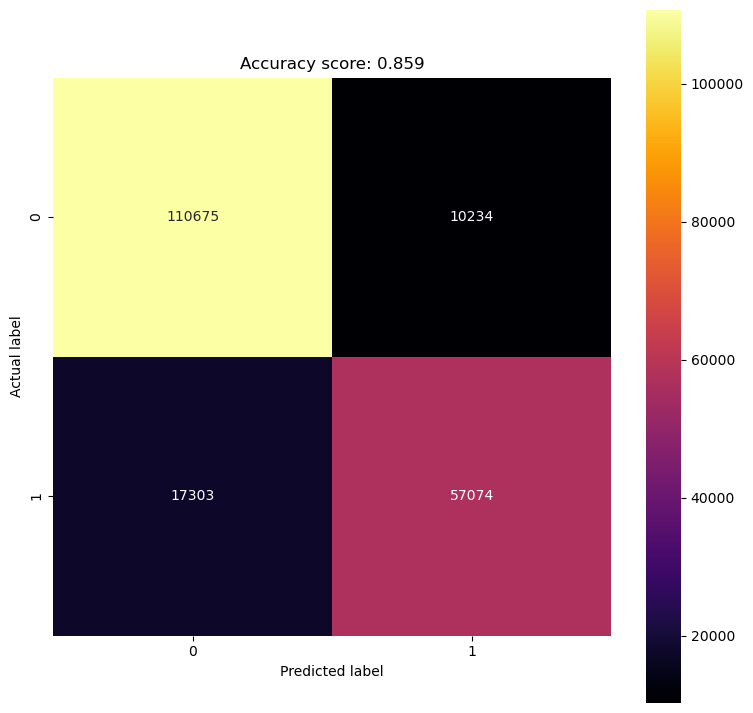

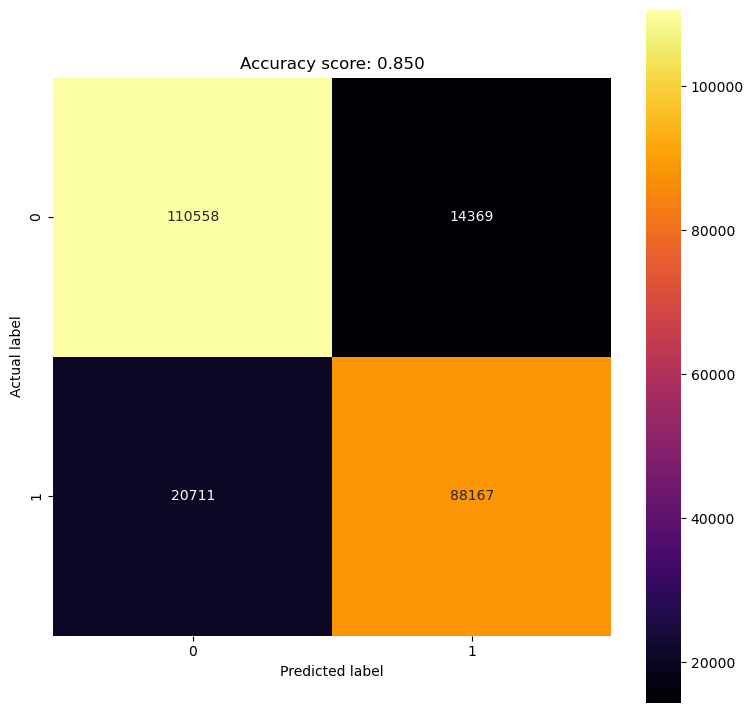

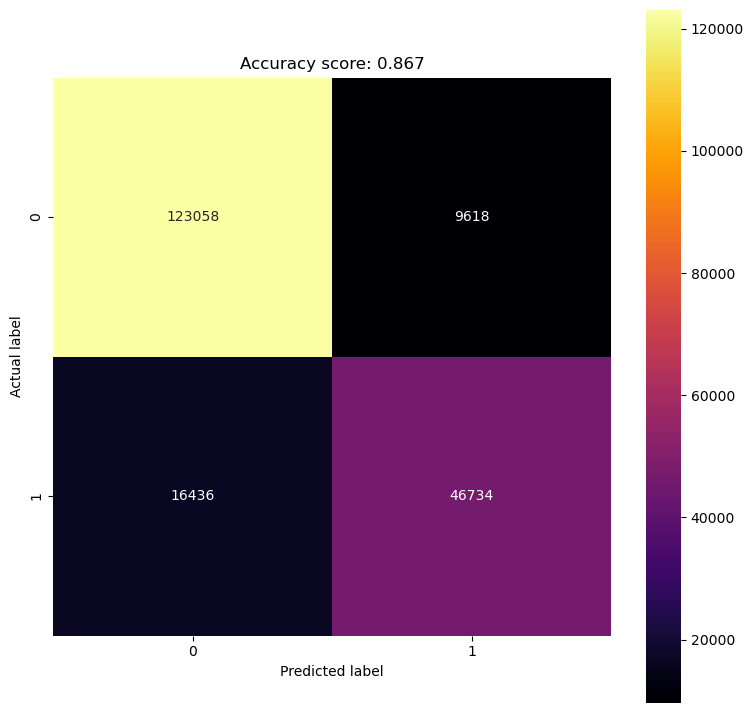

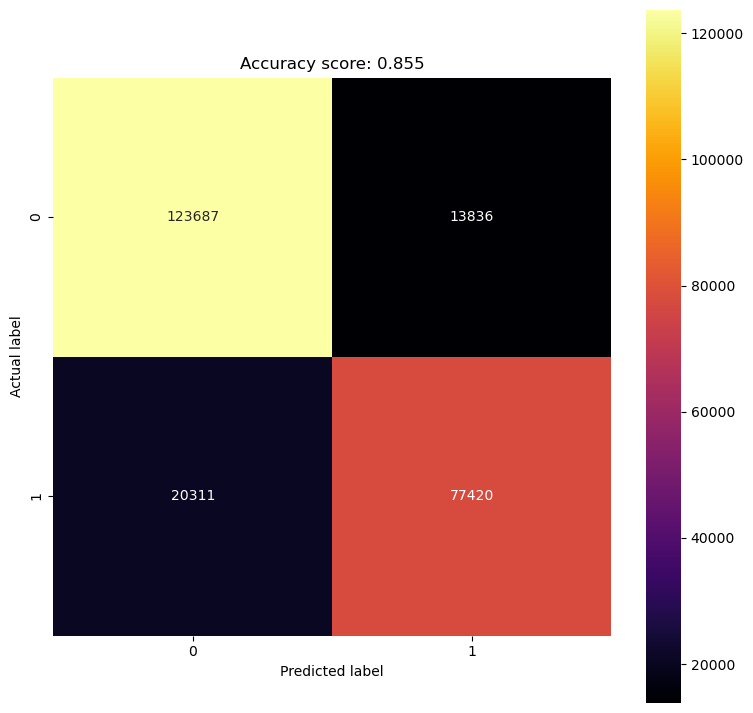

In [53]:
for asc_desc in np.unique(dataframe['sat:orbit_state']):
    for vv_vh in np.unique(dataframe['band']):
        new_dataframe = dataframe[(dataframe['sat:orbit_state']==asc_desc) & (dataframe['band']==vv_vh)]

        X = new_dataframe[['ratio_images','local_incidence_angle','forest_cover_fraction','snow_class']]
        y = new_dataframe['modis_binary']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
        model = LogisticRegression()
        model.fit(X_train, y_train)

        score = model.score(X_test,y_test)
        cm = confusion_matrix(y_test,model.predict(X_test))
        f,ax=plt.subplots(figsize=(9,9))
        sns.heatmap(cm, annot=True, fmt=".0f", square = True, cmap = 'inferno',ax=ax);
        ax.set_ylabel('Actual label');
        ax.set_xlabel('Predicted label');
        ax.set_title(f'Accuracy score: {score:.3f}');

In [32]:
X.values.shape

(1176266, 1)

In [33]:
difference_array.shape

NameError: name 'difference_array' is not defined

In [ ]:

index

In [ ]:
model.predict_proba(X)[index]

In [ ]:
np.array(X).shape

In [ ]:
np.array(X)[index]

In [ ]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

In [ ]:
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [ ]:
# X_train = X_train.values.reshape(-1, 1)
# X_test = X_test.values.reshape(-1, 1)

In [ ]:
# model.predict_proba(X_train)

In [ ]:
# from sklearn.metrics import roc_curve

# # Get the predicted probabilities
# y_pred_proba = model.predict_proba(X_test)[:, 1]

# # Compute the ROC curve
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# # Compute the Youden's J statistic
# J = tpr - fpr

# # Find the index of the maximum value of J
# ix = np.argmax(J)

# # Find the optimal threshold
# optimal_threshold = thresholds[ix]

# print('Optimal threshold:', optimal_threshold)

In [ ]:
# from sklearn.metrics import classification_report

# y_pred = model.predict(X_test)
# print(classification_report(y_test, y_pred))

In [ ]:
# clf = RandomForestClassifier(max_depth=2, random_state=0)
# clf.fit(X, y)
# y_pred = clf.predict(X_test)
# print(classification_report(y_test, y_pred))

In [ ]:
clf.feature_importances_

In [ ]:
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_det.html#sphx-glr-auto-examples-model-selection-plot-det-py detection trade off curve

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score roc_auc_score

In [ ]:
from sklearn.decomposition import PCA
new_dataframe_pca = new_dataframe[['ratio_images','local_incidence_angle','forest_cover_fraction','snow_class']]
pca = PCA(n_components=3,whiten=True)


In [ ]:
pca = pca.fit(new_dataframe_pca)

In [ ]:
pca.